- packages

In [1]:
# general
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import os, yaml, requests
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('ggplot')

`functions`

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

`set the connection to the database`

In [3]:
db_conn_post = get_db_conn_post("key_postgresql.yaml")

query to get the data

In [4]:
q = """
    select
            *
    from
            kaggle_data.starbucks.survey_raw;
"""

`load the data into pandas dataframe`

In [5]:
df_raw = pd.read_sql(sql = q, con = db_conn_post)
df_raw.head(3)

C:\Users\migue\AppData\Local\Temp/ipykernel_10768/3493397046.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(sql = q, con = db_conn_post)


,Timestamp,1. Your Gender,2. Your Age,3. Are you currently....?,4. What is your annual income?,5. How often do you visit Starbucks?,6. How do you usually enjoy Starbucks?,7. How much time do you normally spend during your visit?,8. The nearest Starbucks's outlet to you is...?,9. Do you have Starbucks membership card?,...,"11. On average, how much would you spend at Starbucks per visit",12. How would you rate the quality of Starbucks compared to oth,13. How would you rate the price range at Starbucks?,14. How important are sales and promotions in your purchase dec,"15. How would you rate the ambiance at Starbucks? (lighting, mu",16. You rate the WiFi quality at Starbucks as..,"17. How would you rate the service at Starbucks? (Promptness, f",18. How likely you will choose Starbucks for doing business mee,19. How do you come to hear of promotions at Starbucks? Check a,20. Will you continue buying at Starbucks?
0,2019/10/01 12:38:43 PM GMT+8,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Dine in,Between 30 minutes to 1 hour,within 1km,Yes,...,Less than RM20,4,3,5,5,4,4,3,Starbucks Website/Apps;Social Media;Emails;Dea...,Yes
1,2019/10/01 12:38:54 PM GMT+8,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Take away,Below 30 minutes,1km - 3km,Yes,...,Less than RM20,4,3,4,4,4,5,2,Social Media;In Store displays,Yes
2,2019/10/01 12:38:56 PM GMT+8,Male,From 20 to 29,Employed,"Less than RM25,000",Monthly,Dine in,Between 30 minutes to 1 hour,more than 3km,Yes,...,Less than RM20,4,3,4,4,4,4,3,In Store displays;Billboards,Yes


In [6]:
q = """
    select
            *
    from
            kaggle_data.starbucks.survey_clean;
"""

df_clean = pd.read_sql(sql = q, con = db_conn_post)
df_clean.head(3)

C:\Users\migue\AppData\Local\Temp/ipykernel_10768/3509780285.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_clean = pd.read_sql(sql = q, con = db_conn_post)


,Id,gender,age,status,income,visitNo,method,timeSpend,location,membershipCard,...,chooseRate,promoMethodApp,promoMethodSoc,promoMethodEmail,promoMethodDeal,promoMethodFriend,promoMethodDisplay,promoMethodBillboard,promoMethodOthers,loyal
0,1,1,1,0,0,3,0,1,0,0,...,3,1,1,1,1,1,1,1,1,0
1,2,1,1,0,0,3,2,0,1,0,...,2,1,1,1,1,1,1,1,1,0
2,3,0,1,2,0,2,0,1,2,0,...,3,1,1,1,1,1,1,1,1,0


Ok, once we have the the raw information we can deep into the data<br>
But the first step is to check the data quality

well, at lest only one row has null values<br>
and we can start with the gender, age or occupation with null values

In [7]:
df_raw.isnull().sum()

Timestamp                                                          0
1. Your Gender                                                     0
2. Your Age                                                        0
3. Are you currently....?                                          0
4. What is your annual income?                                     0
5. How often do you visit Starbucks?                               0
6. How do you usually enjoy Starbucks?                             1
7. How much time do you normally  spend during your visit?         0
8. The nearest Starbucks's outlet to you is...?                    0
9. Do you have Starbucks membership card?                          0
10. What do you most frequently purchase at Starbucks?             0
11. On average, how much would you spend at Starbucks per visit    0
12. How would you rate the quality of Starbucks compared to oth    0
13. How would you rate the price range at Starbucks?               0
14. How important are sales and pr

In [8]:
columns = df_raw.columns

In [9]:
gender_count = pd.DataFrame(df_raw[columns[1]].value_counts())

`gender`

In [10]:
gender_count

,1. Your Gender
Female,65
Male,57


`age`

In [11]:
age_count = pd.DataFrame(df_raw[columns[2]].value_counts())

In [12]:
age_count

,2. Your Age
From 20 to 29,85
From 30 to 39,17
Below 20,13
40 and above,7


`occupation`

In [13]:
occupation_count = pd.DataFrame(df_raw[columns[3]].value_counts())

In [14]:
occupation_count

,3. Are you currently....?
Employed,61
Student,42
Self-employed,17
Housewife,2


Based on the charts, we can infer that the majority of customers fall into the category of young individuals who are either employed or students

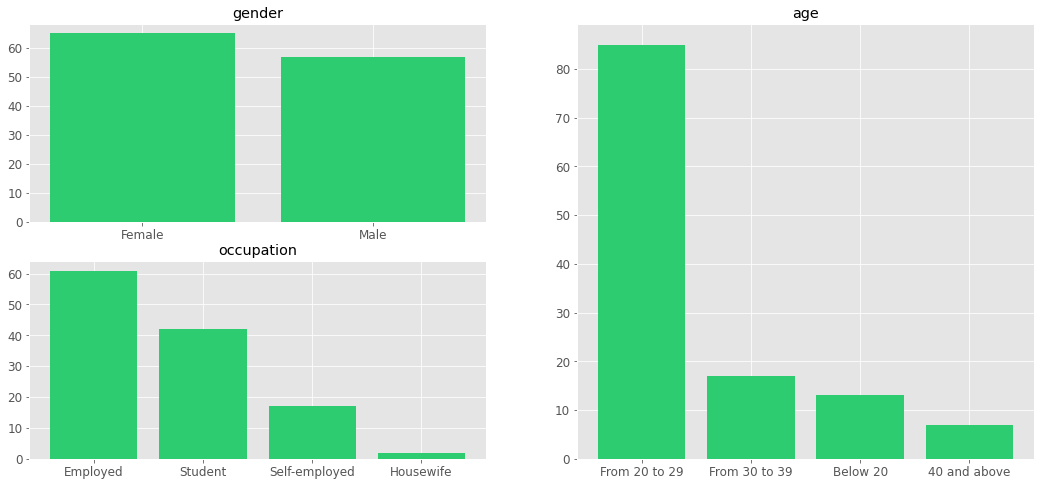

In [15]:
plt.figure(figsize = (18, 8))

# gender
plt.subplot(221)
plt.bar(x = gender_count.index, 
        height = gender_count[gender_count.columns[0]],
        color = '#2ECC71'
        )
plt.title('gender')

# age
plt.subplot(122)
plt.bar(x = age_count.index, 
        height = age_count[age_count.columns[0]],
        color = '#2ECC71'
        )
plt.title('age')

# occupation
plt.subplot(223)
plt.bar(x = occupation_count.index, 
        height = occupation_count[occupation_count.columns[0]],
        color = '#2ECC71'
        )
plt.title('occupation')

plt.show()

Based on the next chart, most of the people buy coffe or cold drinks

In [16]:
items_count = pd.DataFrame(df_raw[columns[10]].value_counts())

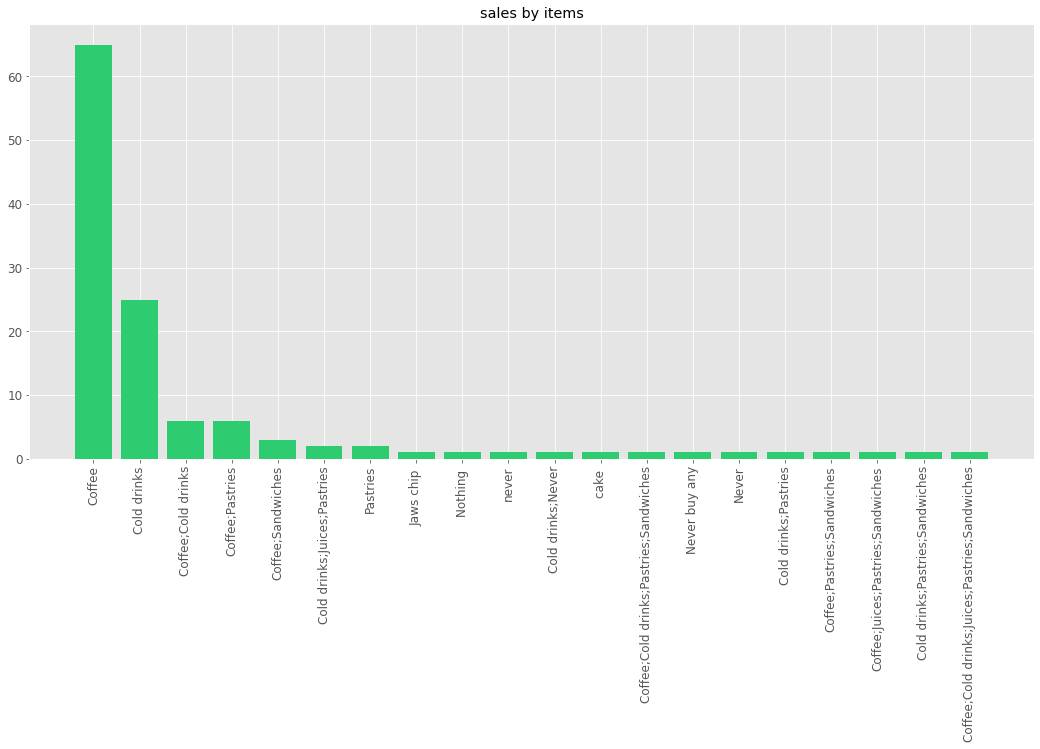

In [19]:
plt.figure(figsize = (18, 8))

# items
plt.bar(x = items_count.index, 
        height = items_count[items_count.columns[0]],
        color = '#2ECC71'
        )
plt.title('sales by items')
plt.xticks(rotation = 90)
plt.show()

**What happend with the loyal customers?**

In [24]:
df_clean.head(1)

,Id,gender,age,status,income,visitNo,method,timeSpend,location,membershipCard,...,chooseRate,promoMethodApp,promoMethodSoc,promoMethodEmail,promoMethodDeal,promoMethodFriend,promoMethodDisplay,promoMethodBillboard,promoMethodOthers,loyal
0,1,1,1,0,0,3,0,1,0,0,...,3,1,1,1,1,1,1,1,1,0


In [26]:
df_clean_loyal = df_clean[df_clean['loyal'] == 1]

In [29]:
columns = df_clean.columns

`gender`

In [34]:
gender_count = pd.DataFrame(df_clean_loyal[columns[1]].value_counts())

In [35]:
gender_count

,gender
1,13
0,10


`age`

In [36]:
age_count = pd.DataFrame(df_clean_loyal[columns[2]].value_counts())

In [37]:
age_count

,age
1,17
0,3
2,2
3,1


`occupation`

In [38]:
occupation_count = pd.DataFrame(df_clean_loyal[columns[3]].value_counts())

In [39]:
occupation_count

,status
0,12
2,10
1,1


Based on the charts, we can infer that the majority of loyal customers fall into the category of young female who are either employed or students

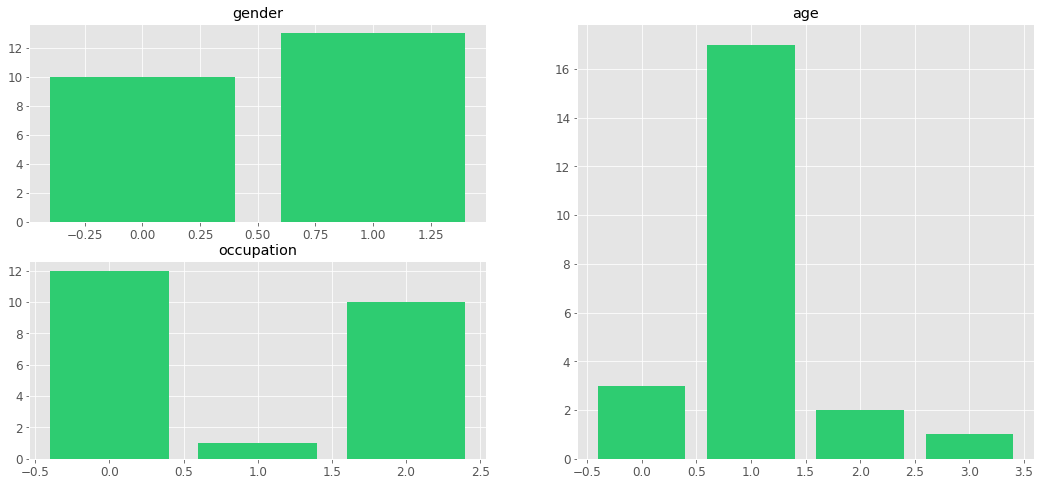

In [40]:
plt.figure(figsize = (18, 8))

# gender
plt.subplot(221)
plt.bar(x = gender_count.index, 
        height = gender_count[gender_count.columns[0]],
        color = '#2ECC71'
        )
plt.title('gender')

# age
plt.subplot(122)
plt.bar(x = age_count.index, 
        height = age_count[age_count.columns[0]],
        color = '#2ECC71'
        )
plt.title('age')

# occupation
plt.subplot(223)
plt.bar(x = occupation_count.index, 
        height = occupation_count[occupation_count.columns[0]],
        color = '#2ECC71'
        )
plt.title('occupation')

plt.show()